# Kaggle Titanic workflow  
Predicting survival from the sinking of the titanic using passenger data  

Aine Fairbrother-Browne  
12/20  

## Setup

In [1]:
# import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# import ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold # for K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.metrics import confusion_matrix

# settings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autotime

## Import data

In [2]:
# import data
os.chdir("/home/abrowne/ML/kaggle_titanic_survival/")

# test data
train_data = pd.read_csv(open("./data/train.csv"), encoding="utf-8", engine='python', index_col=0, header=0)

# train data
test_data = pd.read_csv(open("./data/test.csv"), encoding="utf-8", engine='python', index_col=0, header=0)

time: 55 ms


## View data

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


* age:  
Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  

* sibsp:  
The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

* parch:  
The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them  

In [3]:
print(train_data.shape) # 891 passengers, 11 features
train_data.head(10)

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


time: 29.2 ms


## Dealing with missing data

In [4]:
def plot_perecent_missing(df):
    
    """
    Calculate number of missing values present in each df column and plot the result as a barplot
    """
    
    # calculate how many null/na vals each feature
    percent_na = [(df.iloc[:,i].isnull().sum()/len(df.iloc[:,i]))*100 for i in range(len(df.columns))]

    for x in zip(df.columns, percent_na):
        print(x)

    # plot 
    p = sns.barplot(x=df.columns, y=percent_na)
    p.set_xticklabels(rotation=45, labels=df.columns)
    p.set_ylabel('Percent missing data')
    plt.title('Number of nan vals per feature')
    return(p)

time: 3.89 ms


Visualising % missing data  

('Survived', 0.0)
('Pclass', 0.0)
('Name', 0.0)
('Sex', 0.0)
('Age', 19.865319865319865)
('SibSp', 0.0)
('Parch', 0.0)
('Ticket', 0.0)
('Fare', 0.0)
('Cabin', 77.10437710437711)
('Embarked', 0.22446689113355783)


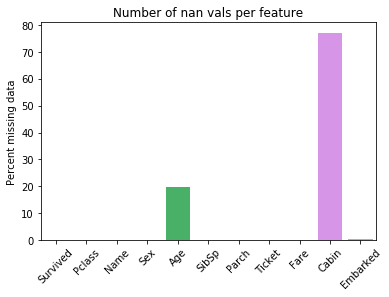

time: 506 ms


In [5]:
plot_perecent_missing(df=train_data);

Removing cabin feature as it has so many null values

In [6]:
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

time: 6.08 ms


Visualising the distribution of Age

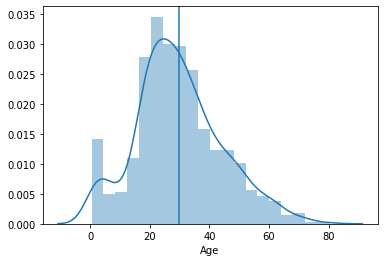

time: 375 ms


In [7]:
sns.distplot(train_data.Age[~np.isnan(train_data.Age)]);
plt.axvline(train_data.Age.mean())

Age is skewed about the mean, so use a median fill to impute missing values

In [28]:
print(test_data.groupby(['Sex', 'Pclass'])['Age'].agg(['median', 'count']).round(1))

               median  count
Sex    Pclass               
female 1         41.0     50
       2         24.0     30
       3         22.0     72
male   1         42.0     57
       2         28.0     63
       3         24.0    146
time: 16 ms


Sex and class have different median ages, so use a more refined median fill than a blanket one to retain more information in the Age variable

In [20]:
train_data['Age'].fillna(train_data.groupby(["Sex","Pclass"])['Age'].transform('median'), inplace=True)
test_data['Age'].fillna(test_data.groupby(["Sex","Pclass"])['Age'].transform('median'), inplace=True)

time: 17 ms


## Feature engineering

In [21]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095
time: 4.7 ms


## Trying models  
Try running with different vectors of parameters  
Then try with hyperparameter tuning & K-fold CV to avoid overfitting

### 1. Random forest classifier  

In [22]:
# import the RFC from sklearn
from sklearn.ensemble import RandomForestClassifier

# function to run rfc for fecture vectors
def run_rfc_SPLIT(feature_vector):
    
    """
    Run RFC on test data split 70:30 - can test different models until ready to use full set and submit
    """
    
    print('------------------------------------------------------')
    print('features selected: ', feature_vector)
    # define features that we want to use to predict survival
    features = feature_vector

    # selecting features to train the model on
    pred_features = pd.get_dummies(train_data[features])
    target = train_data["Survived"]

    # splitting training set test:train 30:70
    X_train,X_test,y_train,y_test = train_test_split(pred_features, target, test_size=0.3, random_state=42)

    # initialise RFC model
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

    # fit model
    model.fit(X_train, y_train)

    # get predictions 
    predictions = model.predict(X_test)

    print('The accuracy of the Random Forest Classifier is', round(accuracy_score(predictions, y_test)*100,2))
    print('------------------------------------------------------')
    

time: 4.18 ms


In [23]:
run_rfc_SPLIT(feature_vector = ["Pclass", "Sex", "SibSp", "Parch", "Age"])

------------------------------------------------------
features selected:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Age']
The accuracy of the Random Forest Classifier is 82.84
------------------------------------------------------
time: 259 ms


In [24]:
def run_rfc_FULL(feature_vector, submission_n=None):
    
        """
        Run on full dataset, and generate output formatted for submissiomn
        """
        
        target = train_data["Survived"]
        
        # getting training and test features
        pred_features_train = pd.get_dummies(train_data[feature_vector])
        pred_features_test = pd.get_dummies(test_data[feature_vector])  
        
        # initialise RFC model
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
        
        # fit model
        model.fit(pred_features_train, target)
        
        # get predictions
        predictions = model.predict(pred_features_test)
        
        if submission_n!=None:
            # export 
            output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
            output.to_csv('./submissions/submission{}.csv'.format(submission_n), index=False)

time: 3.35 ms


In [25]:
run_rfc_FULL(feature_vector = ["Pclass", "Sex", "SibSp", "Parch", "Age"], submission_n=3)

time: 270 ms
